# DeepLearning using Tensorflow (Transformers)

## Data Preparation and Environment Setup

Second round of data preparation was essential and number of classes were reduced. 

Details in this [notebook](https://github.com/niteeshhegde/classified-ad-demand/blob/master/data-preprocessing/dataprep-pandas.ipynb) 

Google's Colab has free GPUs and users can run 2 sessions at a time.

This notebook was run on colab with Python 3 and GPU with 36Gi RAM.

Also here text data from Title and Description are taken intoo consideration.

In this tensorflow model, embeddings are taken from ruber transformer for title and description.

Details : https://huggingface.co/DeepPavlov/rubert-base-cased

Authenticate into gcp

In [ ]:
from google.colab import auth

In [ ]:
auth.authenticate_user()

In [ ]:
!gcloud config set project skilful-orb-255314

Updated property [core/project].


Copy the dataset 

In [ ]:
!gsutil cp gs://dataproc-e3bd1f7b-2e29-4da6-a5c4-077c164fd32a-us-central1/avito/test/three_class_model_train_param_title_desc_params.csv /train.csv

Copying gs://dataproc-e3bd1f7b-2e29-4da6-a5c4-077c164fd32a-us-central1/avito/test/three_class_model_train_param_title_desc_params.csv...
| [1 files][712.8 MiB/712.8 MiB]                                                
Operation completed over 1 objects/712.8 MiB.                                    


In [ ]:
!pip install gcsfs

In [ ]:
import pandas as pd
import numpy as np
import gcsfs

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix 
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df_train = pd.read_csv('/train.csv')
df_train.head()

,region_en,category_name_en,parent_category_name_en,user_type,weekend,price,description,title,param_1,param_2,param_3,description_len,title_len,param_1_len,param_2_len,param_3_len,item_seq_number,image_present,image_top_1,deal_class_5
0,Sverdlovsk oblast,Children's products and toys,Personal belongings,Private,0,400.0,"Кокон для сна малыша,пользовались меньше месяц...",Кокоби(кокон для сна),Постельные принадлежности,,,7,3,2,0,0,2,False,1008.0,Poor
1,Samara oblast,Furniture and interior,For the home and garden,Private,1,3000.0,"Стойка для одежды, под вешалки. С бутика.",Стойка для Одежды,Другое,,,7,3,1,0,0,19,False,692.0,Poor
2,Rostov oblast,Audio and video,Consumer electronics,Private,1,4000.0,"В хорошем состоянии, домашний кинотеатр с blu ...",Philips bluray,"Видео, DVD и Blu-ray плееры",,,17,2,5,0,0,9,False,3032.0,Okay
3,Tatarstan,Children's products and toys,Personal belongings,Company,0,2200.0,Продам кресло от0-25кг,Автокресло,Автомобильные кресла,,,3,1,2,0,0,286,False,796.0,Good
4,Volgograd oblast,Cars,Transport,Private,0,40000.0,Все вопросы по телефону.,"ВАЗ 2110, 2003",С пробегом,ВАЗ (LADA),2110,4,3,2,2,1,3,False,2264.0,Poor


In [ ]:
X = df_train[['region_en','category_name_en','user_type','weekend','price','description','description_len','title','title_len','param_1_len','param_2_len','param_3_len','param_1','param_2','param_3']]
y = df_train[['deal_class_5']]
X_enc = pd.get_dummies(X, columns=['region_en','user_type','category_name_en'], drop_first = True)
X_enc.head()

,weekend,price,description,description_len,title,title_len,param_1_len,param_2_len,param_3_len,param_1,param_2,param_3,region_en_Bashkortostan,region_en_Belgorod oblast,region_en_Chelyabinsk oblast,region_en_Irkutsk oblast,region_en_Kaliningrad oblast,region_en_Kemerovo oblast,region_en_Khanty-Mansi Autonomous Okrug,region_en_Krasnodar Krai,region_en_Krasnoyarsk Krai,region_en_Nizhny Novgorod oblast,region_en_Novosibirsk oblast,region_en_Omsk oblast,region_en_Orenburg oblast,region_en_Perm Krai,region_en_Rostov oblast,region_en_Samara oblast,region_en_Saratov oblast,region_en_Stavropol Krai,region_en_Sverdlovsk oblast,region_en_Tatarstan,region_en_Tula oblast,region_en_Tyumen oblast,region_en_Udmurtia,region_en_Vladimir oblast,region_en_Volgograd oblast,region_en_Voronezh oblast,region_en_Yaroslavl oblast,user_type_Private,...,category_name_en_Cars,category_name_en_Cats,category_name_en_Children's clothing and shoes,category_name_en_Children's products and toys,"category_name_en_Clothing, shoes, accessories",category_name_en_Collecting,category_name_en_Commercial property,category_name_en_Desktop computers,category_name_en_Dogs,category_name_en_Equipment for business,category_name_en_Food,category_name_en_Furniture and interior,"category_name_en_Games, consoles and software",category_name_en_Garages and Parking spaces,category_name_en_Health and beauty,"category_name_en_Houses, villas, cottages",category_name_en_Hunting and fishing,category_name_en_Land,category_name_en_Laptops,category_name_en_Motorcycles and bikes,category_name_en_Musical instruments,category_name_en_Offer services,category_name_en_Office equipment and consumables,category_name_en_Other animals,category_name_en_Pet products,category_name_en_Phones,category_name_en_Photo,category_name_en_Plants,category_name_en_Products for computer,category_name_en_Property abroad,category_name_en_Ready business,category_name_en_Repair and construction,category_name_en_Room,category_name_en_Sports and recreation,category_name_en_Tablets and e-books,category_name_en_Tableware and goods for kitchen,category_name_en_Tickets and travel,category_name_en_Trucks and buses,category_name_en_Watches and jewelry,category_name_en_Water transport
0,0,400.0,"Кокон для сна малыша,пользовались меньше месяц...",7,Кокоби(кокон для сна),3,2,0,0,Постельные принадлежности,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3000.0,"Стойка для одежды, под вешалки. С бутика.",7,Стойка для Одежды,3,1,0,0,Другое,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,4000.0,"В хорошем состоянии, домашний кинотеатр с blu ...",17,Philips bluray,2,5,0,0,"Видео, DVD и Blu-ray плееры",,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2200.0,Продам кресло от0-25кг,3,Автокресло,1,2,0,0,Автомобильные кресла,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,40000.0,Все вопросы по телефону.,4,"ВАЗ 2110, 2003",3,2,2,1,С пробегом,ВАЗ (LADA),2110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re, string, timeit

In [ ]:
from keras.preprocessing import text,sequence
from sklearn.utils import resample

Using TensorFlow backend.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size = 0.20, random_state = 42, stratify=y)

In [ ]:
LE = LabelEncoder()
y_train['deal_class_5'] = LE.fit_transform(y_train.deal_class_5)
y_test['deal_class_5'] = LE.fit_transform(y_test.deal_class_5)
X_train['deal_class_5'] = y_train['deal_class_5']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

## Resampling the data

In [ ]:
df_2 = X_train[X_train['deal_class_5']==2]
df_1= X_train[X_train['deal_class_5']==1]
df_0= X_train[X_train['deal_class_5']==0]
# Downsample majority class
df_2 = resample(df_2, 
                                 replace=False,    # sample without replacement
                                 n_samples=700000,     # to match minority class
                                 random_state=123) # reproducible results
df_1 = resample(df_1, 
                                 replace=True,    # sample without replacement
                                 n_samples=700000,     # to match minority class
                                 random_state=123) 
df_0 = resample(df_0, 
                                 replace=True,    # sample without replacement
                                 n_samples=700000,     # to match minority class
                                 random_state=123) 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_2, df_1, df_0])
 
# Display new class counts
df_downsampled.deal_class_5.value_counts()

2    700000
1    700000
0    700000
Name: deal_class_5, dtype: int64

In [ ]:
y_train = df_downsampled['deal_class_5']
X_train = df_downsampled.drop(columns=['deal_class_5'])

## Transformer Embeddings

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 890kB 16.7MB/s 
     |████████████████████████████████| 3.0MB 14.0MB/s 
     |████████████████████████████████| 1.1MB 46.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=2c209483940651538ee99eedf47bdd4dc5fa1dc720529fee4272071b50c0341c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import tensorflow as tf
import transformers
from numpy import random
from transformers import AutoTokenizer

Download the tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

Tokenize title and description

In [ ]:
enc_desc = X_train['description']
enc_title = X_train['title']

In [ ]:
encode = lambda x: tokenizer.encode(x)

In [ ]:
enc_title = enc_title.map(encode)
enc_desc = enc_desc.map(encode)

In [ ]:
X_train['embed_title'] = enc_title
X_train['embed_desc'] = enc_desc

In [ ]:
X_test_title = X_test['title']
X_test_desc = X_test['description']

In [ ]:
X_test_title = X_test_title.map(encode)
X_test_desc = X_test_desc.map(encode)

In [ ]:
X_train.to_csv('gs://dataproc-e3bd1f7b-2e29-4da6-a5c4-077c164fd32a-us-central1/avito/tfdata/train_embed.csv',index=False)

In [ ]:
max_features = 100000
maxlen_title = 50
maxlen_desc = 150
embed_size = 300

For getting the saved X_Train which contains the embeddings:

In [ ]:
#only when newly loaded from csv
!gsutil cp gs://dataproc-e3bd1f7b-2e29-4da6-a5c4-077c164fd32a-us-central1/avito/tfdata/train_embed.csv /train.csv
X_train = pd.read_csv('/train.csv')
listing = lambda x: x.strip('][').split(', ')
X_train['embed_title'] = X_train['embed_title'].map(listing)
X_train['embed_desc'] = X_train['embed_desc'].map(listing)

Padding for title and description

In [ ]:
X_train_title = sequence.pad_sequences(X_train['embed_title'], maxlen=maxlen_title)
X_train_desc = sequence.pad_sequences(X_train['embed_desc'], maxlen=maxlen_desc)
X_test_title = sequence.pad_sequences(X_test_title, maxlen=maxlen_title)
X_test_desc = sequence.pad_sequences(X_test_desc, maxlen=maxlen_desc)

In [ ]:
X_train = X_train.drop(columns=['description', 'title', 'param_1', 'param_2', 'param_3', 'embed_title', 'embed_desc'])
X_test = X_test.drop(columns=['description', 'title', 'param_1', 'param_2', 'param_3', 'embed_title', 'embed_desc'])

In [ ]:
sc = StandardScaler()
X_train.loc[:,["price","description_len","title_len","param_1_len","param_2_len","param_3_len"]] = sc.fit_transform(X_train[["price","description_len","title_len","param_1_len","param_2_len","param_3_len"]])
X_test.loc[:,["price","description_len","title_len","param_1_len","param_2_len","param_3_len"]] = sc.transform(X_test[["price","description_len","title_len","param_1_len","param_2_len","param_3_len"]])


In [ ]:
X_test = X_test.to_numpy()
X_train = X_train.to_numpy()
y_test = pd.get_dummies(y_test, columns=['deal_class_5']).to_numpy()
y_train = pd.get_dummies(y_train, columns=['0']).to_numpy()

## Tensorflow Model

In [ ]:
from sklearn import metrics
import tensorflow as tf

from tensorflow import keras as k1
from tensorflow.keras import layers
from tensorflow.keras import Model
print(tf.__version__)

2.2.0


In [ ]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-aqunr239
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-aqunr239
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0d41eeb858e80108db8d13ba25867757d7de0fcf9_-cp36-none-any.whl size=124709 sha256=7812aceffaceba678b190c998815dc265cd30836fe4168de6448e15a1d293155
  Stored in directory: /tmp/pip-ephem-wheel-cache-gycdu82z/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [ ]:
pip install tensorflow-addons

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import keras.backend as K
import tensorflow_addons as tfa


In [ ]:
from keras import backend as K
from keras.layers import Input
from keras.layers import Embedding, concatenate,GlobalAveragePooling1D,Dense,Dropout,SpatialDropout1D,Reshape,Flatten
from keras import Model
from keras.callbacks import ModelCheckpoint

In [ ]:
seq_length_title = 50
seq_length_desc = 150

In [ ]:
nlp_input_desc = Input(shape=(seq_length_desc,), name='nlp_input_desc')
nlp_input_title = Input(shape=(seq_length_title,), name='nlp_input_title')
emb1 = Embedding(input_dim=tokenizer.vocab_size,output_dim=1)(nlp_input_title)
emb1 = SpatialDropout1D(0.2)(emb1)
emb1 = Flatten()(emb1)
emb2 = Embedding(input_dim=tokenizer.vocab_size,output_dim=1)(nlp_input_desc)
emb2 = SpatialDropout1D(0.2)(emb2)
emb2 = Flatten()(emb2)
meta_input = Input(shape=(82,), name='meta_input')
x = concatenate([emb1,emb2, meta_input])
x = Dense(512, activation='relu')(x)
x = Dropout(0.05)(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(3, activation='softmax')(x)
model =  Model(inputs=[nlp_input_title,nlp_input_desc, meta_input], outputs=[x])

In [ ]:
early_stopping = k1.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)

In [ ]:
model.compile(optimizer=k1.optimizers.Adam(lr=2e-4),
              loss="categorical_crossentropy",
              metrics=[tfa.metrics.F1Score(num_classes=3,average="macro",threshold=None),"accuracy" ])

In [ ]:
checkpoint_path = "gs://dataproc-e3bd1f7b-2e29-4da6-a5c4-077c164fd32a-us-central1/avito/dl0/transformers2/cp-{epoch:04d}.ckpt"

In [ ]:
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

In [ ]:
model.load_weights("gs://dataproc-e3bd1f7b-2e29-4da6-a5c4-077c164fd32a-us-central1/avito/dl0/transformers/cp-0055.ckpt")

In [ ]:
history = model.fit([X_train_title,X_train_desc,X_train],y_train, epochs=100, callbacks=[cp_callback,early_stopping], validation_split=0.2, shuffle= True,batch_size=2048)

Train on 1680000 samples, validate on 420000 samples
Epoch 1/100
1680000/1680000 [==============================] - 42s 25us/step - loss: 0.4780 - f1_score: 0.0000e+00 - accuracy: 0.8041 - val_loss: 1.0957 - val_f1_score: 0.0000e+00 - val_accuracy: 0.4813
Epoch 2/100
1680000/1680000 [==============================] - 43s 25us/step - loss: 0.4756 - f1_score: 0.0000e+00 - accuracy: 0.8049 - val_loss: 1.1603 - val_f1_score: 0.0000e+00 - val_accuracy: 0.4602
Epoch 3/100
1680000/1680000 [==============================] - 42s 25us/step - loss: 0.4738 - f1_score: 0.0000e+00 - accuracy: 0.8054 - val_loss: 1.1966 - val_f1_score: 0.0000e+00 - val_accuracy: 0.4328
Epoch 4/100
1680000/1680000 [==============================] - 43s 25us/step - loss: 0.4729 - f1_score: 0.0000e+00 - accuracy: 0.8059 - val_loss: 1.0347 - val_f1_score: 0.0000e+00 - val_accuracy: 0.5197
Epoch 5/100
1680000/1680000 [==============================] - 43s 26us/step - loss: 0.4708 - f1_score: 0.0000e+00 - accuracy: 0.8067 -

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input_title (InputLayer)    (None, 50)           0                                            
__________________________________________________________________________________________________
nlp_input_desc (InputLayer)     (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 1)        119547      nlp_input_title[0][0]            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 150, 1)       119547      nlp_input_desc[0][0]             
____________________________________________________________________________________________

In [ ]:
model.load_weights("gs://dataproc-e3bd1f7b-2e29-4da6-a5c4-077c164fd32a-us-central1/avito/dl0/transformers2/cp-0100.ckpt")

## Results

In [ ]:
from matplotlib import pyplot

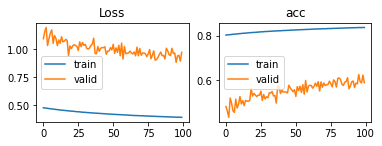

In [ ]:
# plot loss during training
pyplot.subplot(221)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.legend()
pyplot.subplot(222)
pyplot.title('acc')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='valid')
pyplot.legend()

In [ ]:
print('\n# Evaluate on test data')
results = model.evaluate([X_test_title,X_test_desc,X_test], y_test, batch_size=1024)
print('test loss, test acc:', results)


# Evaluate on test data
300685/300685 [==============================] - 6s 21us/step
test loss, test acc: [458257.84921398223, 0.0, 0.8199743628501892]


In [ ]:
actual = np.argmax(y_test, axis=1) 
print('\n# Generate predictions for 3 samples')
predictions = model.predict([X_test_title,X_test_desc,X_test])
result = np.argmax(predictions, axis=1)


# Generate predictions for 3 samples


In [ ]:
print(classification_report(actual,result))

              precision    recall  f1-score   support

           0       0.20      0.01      0.03     32609
           1       0.20      0.11      0.14     16533
           2       0.84      0.97      0.90    251543

    accuracy                           0.82    300685
   macro avg       0.41      0.36      0.36    300685
weighted avg       0.74      0.82      0.77    300685

